# Image Captioning with RNN and LSTMs

In [4]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from Model.rnn_layers import *
from Solver.captioning_solver import CaptioningSolver
from Model.rnn import CaptioningRNN
from Dataset.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from Dataset.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MS-COCO data
We will use the Microsoft COCO dataset for captioning.

In [7]:
# Load COCO data from disk; this returns a dictionary
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


# Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.

Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

# Train Vanilla RNN model

In [47]:
# select 10,000 samples for training
medium_data = load_coco_data(max_train=10000)

rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

rnn_solver = CaptioningSolver(rnn_model, medium_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=200,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=100,
         )

rnn_solver.train()

(Iteration 1 / 2500) loss: 77.185389
(Iteration 101 / 2500) loss: 30.883187
(Iteration 201 / 2500) loss: 27.370886
(Iteration 301 / 2500) loss: 23.816421
(Iteration 401 / 2500) loss: 23.134126
(Iteration 501 / 2500) loss: 21.985248
(Iteration 601 / 2500) loss: 21.522354
(Iteration 701 / 2500) loss: 20.754251
(Iteration 801 / 2500) loss: 22.308378
(Iteration 901 / 2500) loss: 21.058311
(Iteration 1001 / 2500) loss: 23.336615
(Iteration 1101 / 2500) loss: 23.568348
(Iteration 1201 / 2500) loss: 25.916111
(Iteration 1301 / 2500) loss: 26.426489
(Iteration 1401 / 2500) loss: 26.401052
(Iteration 1501 / 2500) loss: 28.043453


KeyboardInterrupt: 

# Test the vanilla RNN model

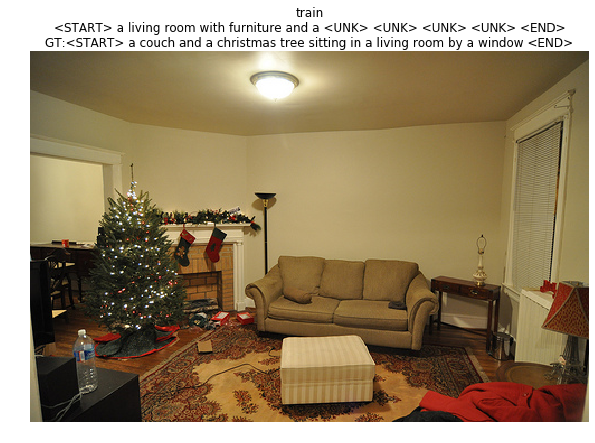

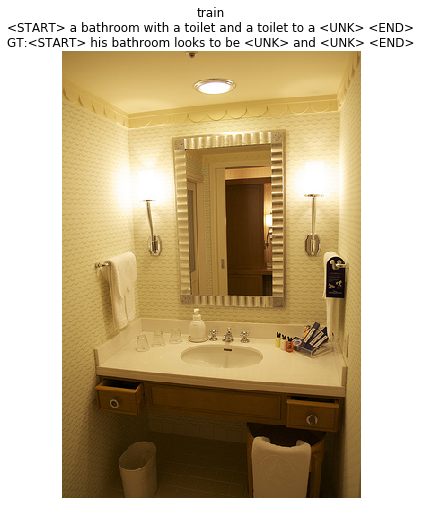

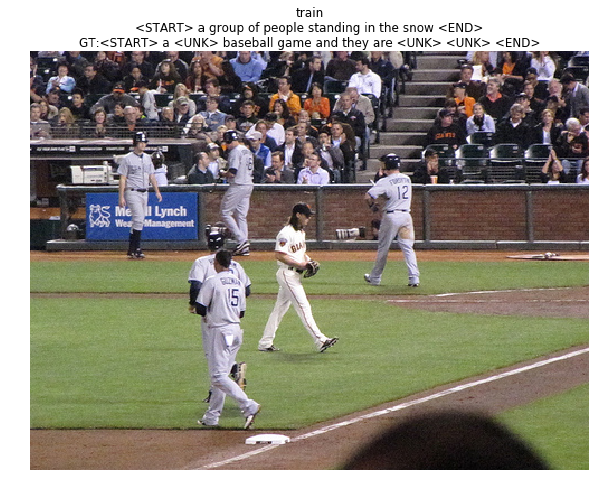

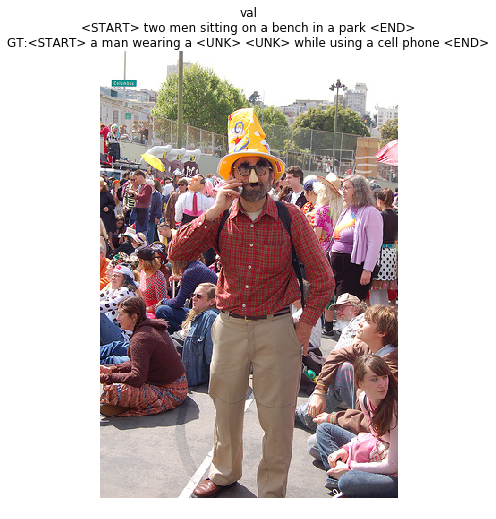

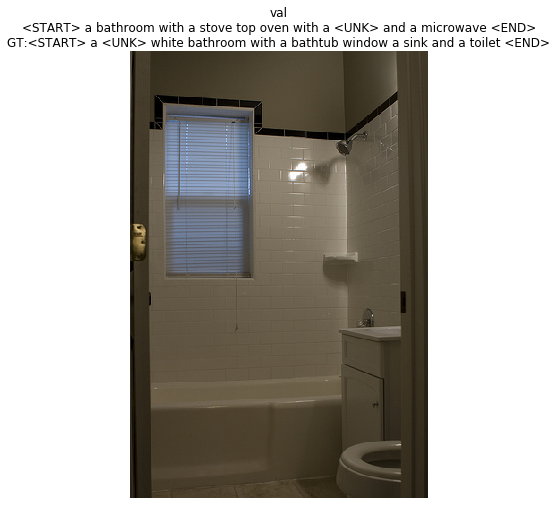

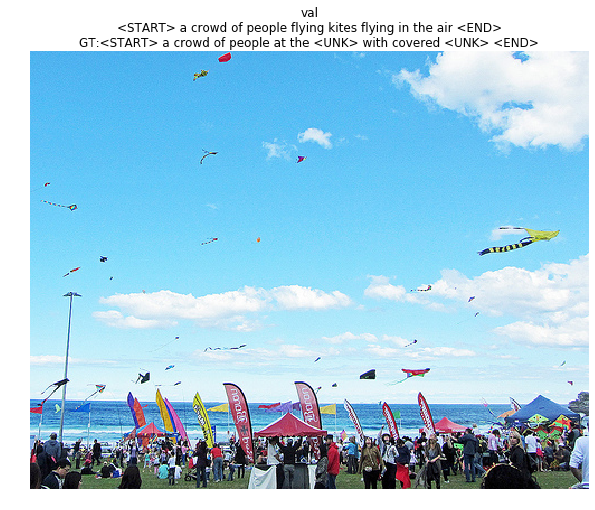

In [49]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(medium_data, split=split, batch_size=3)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = rnn_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Train LSTM RNN model

In [55]:
# select 10,000 samples for training
medium_data = load_coco_data(max_train=2000)

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(rnn_model, medium_data,
           update_rule='adam',
           num_epochs=40,
           batch_size=100,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=50,
         )

lstm_solver.train()

(Iteration 1 / 800) loss: 58.553317
(Iteration 51 / 800) loss: 47.873598
(Iteration 101 / 800) loss: 42.520477
(Iteration 151 / 800) loss: 38.216290
(Iteration 201 / 800) loss: 34.894756
(Iteration 251 / 800) loss: 28.622804
(Iteration 301 / 800) loss: 29.211084
(Iteration 351 / 800) loss: 27.791262
(Iteration 401 / 800) loss: 26.357288
(Iteration 451 / 800) loss: 24.013008
(Iteration 501 / 800) loss: 23.615083
(Iteration 551 / 800) loss: 23.419639
(Iteration 601 / 800) loss: 22.322728
(Iteration 651 / 800) loss: 20.916219
(Iteration 701 / 800) loss: 20.309592
(Iteration 751 / 800) loss: 19.109123


# Test the vanilla RNN model

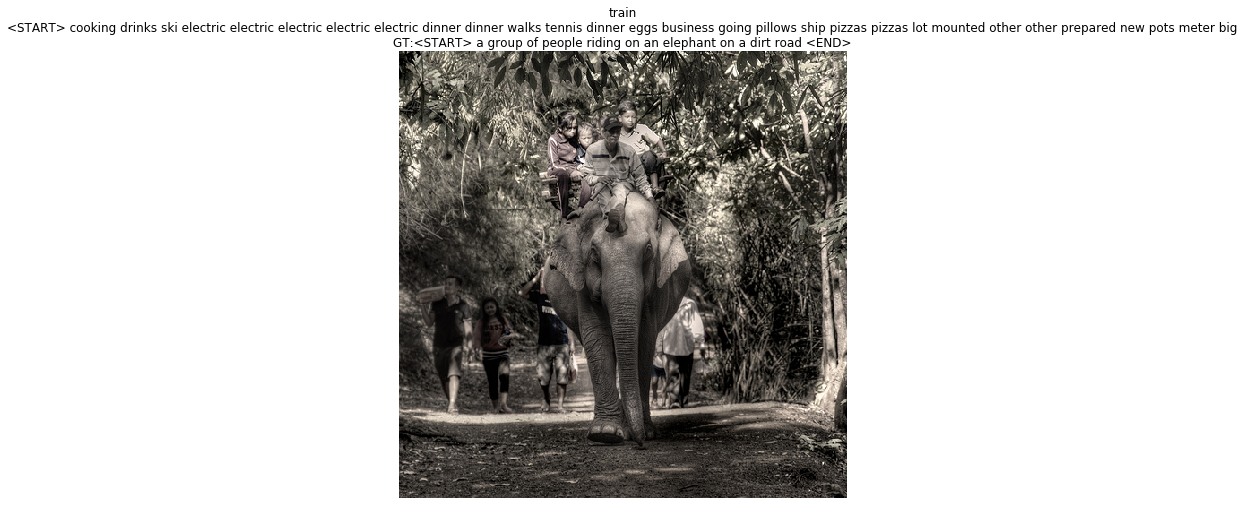

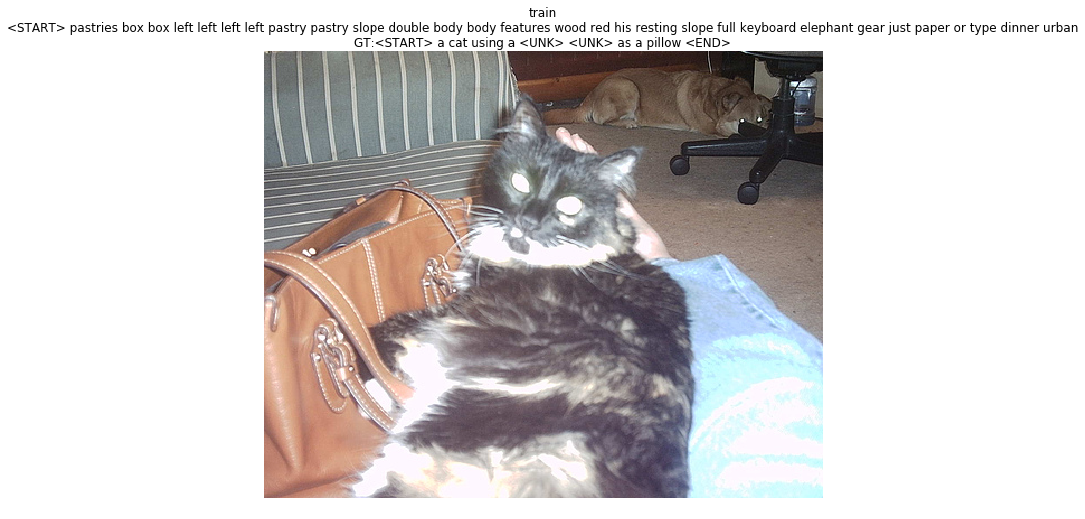

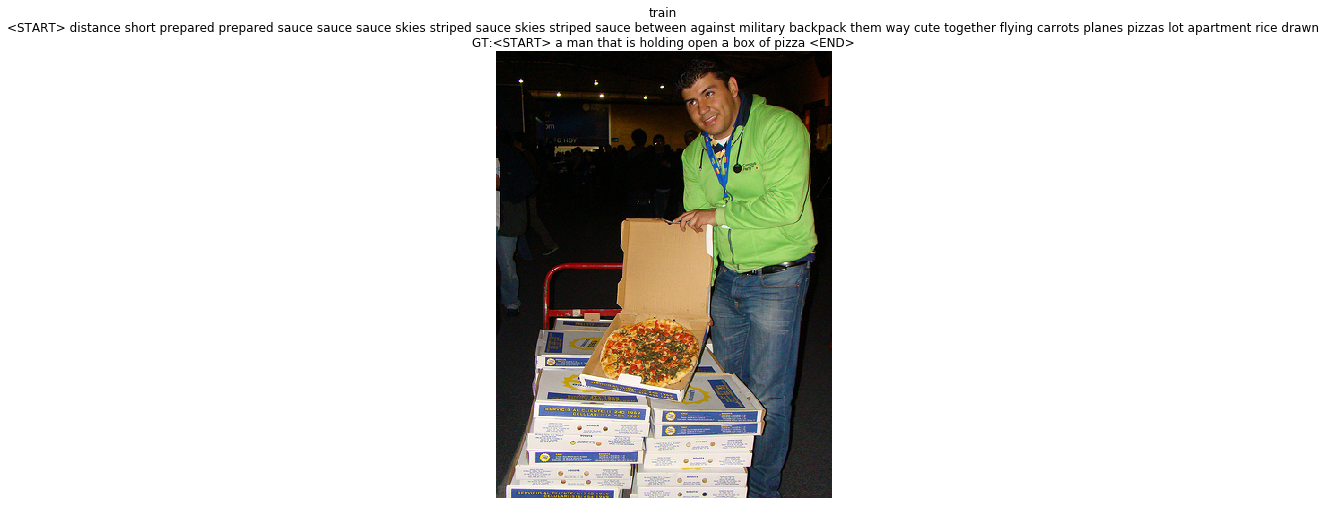

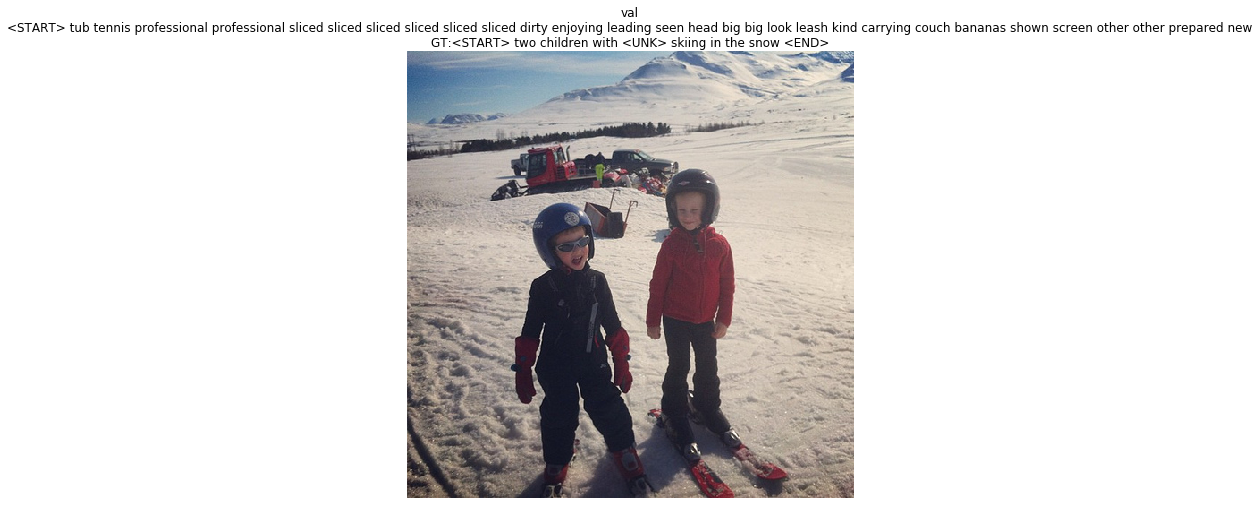

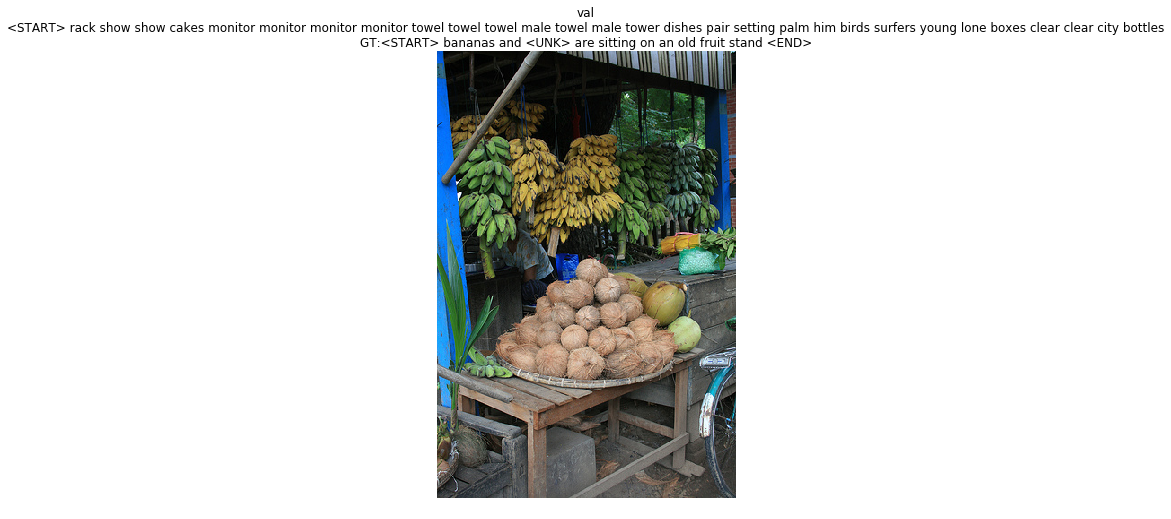

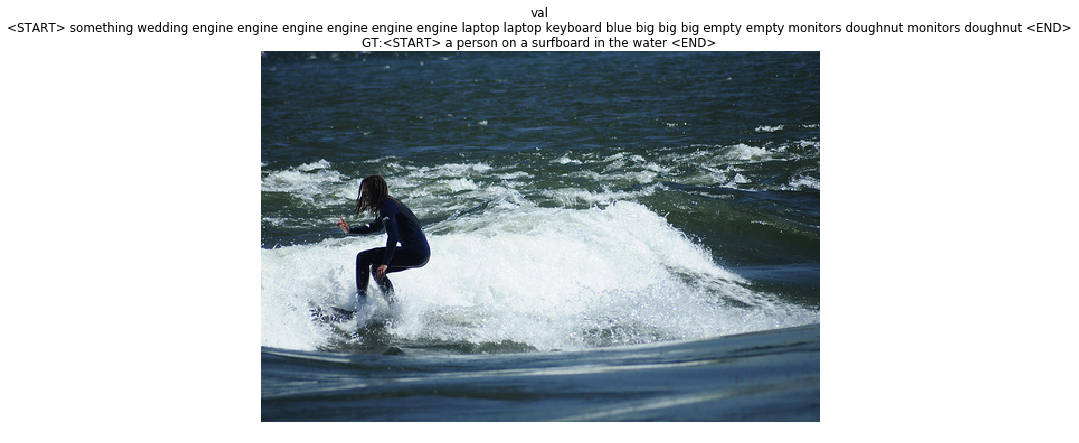

In [56]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(medium_data, split=split, batch_size=3)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()